In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn
import folium
import geopy

## dataframe dictionary

* `nyc_gdf` = inital imported gdf <br>
* `nyc_gdf1` = projected gdf to EPSG:4326 
* `nyc_gdf2` = `nyc_gdf1` with binary values for boolean variables
* `nyc_gdf3` = `nyc_gdf2` groupby hectare (proportions for boolean variables)

## mapping by hectare

1. convert dataframe into geodataframe
2. convert boolean values into binary
3. map based on human interaction, movement, communication
4. map distribution per hectare based on date and shift

In [60]:
nyc_gdf = gpd.read_file('../dataframes/nycsquirrels_clean_1.csv')
nyc_gdf = gpd.GeoDataFrame(nyc_gdf, geometry = gpd.points_from_xy(nyc_gdf.long, nyc_gdf.lat))

In [61]:
nyc_gdf1 = nyc_gdf.set_crs('EPSG:4326')

In [62]:
nyc_gdf1.explore()

In [63]:
nyc_gdf1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   long                                        2968 non-null   object  
 1   lat                                         2968 non-null   object  
 2   unique_squirrel_id                          2968 non-null   object  
 3   hectare                                     2968 non-null   object  
 4   shift                                       2968 non-null   object  
 5   date                                        2968 non-null   object  
 6   hectare_squirrel_number                     2968 non-null   object  
 7   age                                         2968 non-null   object  
 8   primary_fur_color                           2968 non-null   object  
 9   combination_of_primary_and_highlight_color  2968 non-null   object

In [64]:
prim_fur_color_map = {'Gray': 'green', 'Cinnamon': '#8c5f15', 'Black': '#0a2340'}
# nyc_gdf1.explore('primary_fur_color',
                 # color=nyc_gdf1['primary_fur_color'].map(prim_fur_color_map))

In [65]:
def convert_bool_to_int(boolean):
    if boolean == 'TRUE':
        return 1
    elif boolean == 'FALSE':
        return 0

def convert_coord_to_float(coord):
    return float(coord)

long_float = nyc_gdf1['long'].apply(convert_coord_to_float)
lat_float = nyc_gdf1['lat'].apply(convert_coord_to_float)
    
approaches_int = nyc_gdf1['approaches'].apply(convert_bool_to_int)
indifferent_int = nyc_gdf1['indifferent'].apply(convert_bool_to_int)
runs_from_int = nyc_gdf1['runs_from'].apply(convert_bool_to_int)

nyc_gdf2 = nyc_gdf1.assign(long = long_float,
                           lat = lat_float,
                           approaches = approaches_int,
                           indifferent = indifferent_int,
                           runs_from = runs_from_int)

nyc_gdf3 = nyc_gdf2.groupby('hectare').mean()

hectare_freq = nyc_gdf2.groupby('hectare').count().get('long')

human_int_gdf = gpd.GeoDataFrame(nyc_gdf3, geometry = gpd.points_from_xy(nyc_gdf3.long, nyc_gdf3.lat))
human_int_gdf = human_int_gdf.set_crs('EPSG:4326').assign(hectare_freq = hectare_freq)
hectare_freq

hectare
01A    11
01B    27
01C    12
01D    16
01E     8
       ..
42E     6
42F     6
42G     6
42H     6
42I     3
Name: long, Length: 338, dtype: int64

### Human Interaction Plot
#### Set column to 'approaches', 'indifferent', or 'runs_from'

We see that squirrels rarely approach humans.

We see that squirrels are most likely to be indifferent towards humans. 

We see that sqiurrels are most likely to run from humans at the north-west part of the park.

<AxesSubplot:>

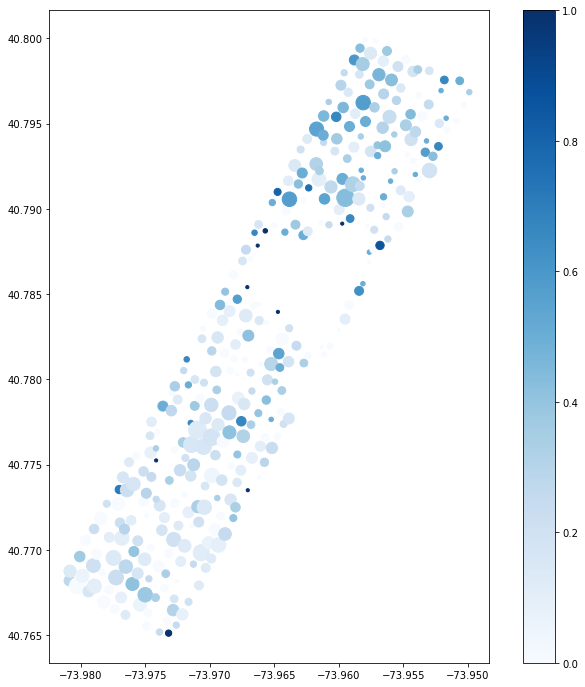

In [66]:
human_int_gdf['hectare_freq_markersize'] = human_int_gdf['hectare_freq'] * 10
human_int_gdf.plot(column = 'runs_from', 
                   markersize = 'hectare_freq_markersize', 
                   cmap = 'Blues',
                   figsize = (12, 12), 
                   legend = True)

In [67]:
nyc_gdf2.columns

Index(['long', 'lat', 'unique_squirrel_id', 'hectare', 'shift', 'date',
       'hectare_squirrel_number', 'age', 'primary_fur_color',
       'combination_of_primary_and_highlight_color', 'location',
       'above_ground_sighter_measurement', 'running', 'chasing', 'climbing',
       'eating', 'foraging', 'kuks', 'quaas', 'moans', 'tail_flags',
       'tail_twitches', 'approaches', 'indifferent', 'runs_from', 'lat_long',
       'community_districts', 'borough_boundaries', 'city_council_districts',
       'police_precincts', 'geometry'],
      dtype='object')

In [68]:
movement = ['running', 'chasing', 'climbing', 'eating', 'foraging']

running_int = nyc_gdf2['running'].apply(convert_bool_to_int)
chasing_int = nyc_gdf2['chasing'].apply(convert_bool_to_int)
climbing_int = nyc_gdf2['climbing'].apply(convert_bool_to_int)
eating_int = nyc_gdf2['eating'].apply(convert_bool_to_int)
foraging_int = nyc_gdf2['foraging'].apply(convert_bool_to_int)

nyc_gdf2 = nyc_gdf2.assign(running = running_int,
                          chasing = chasing_int,
                          climbing = climbing_int,
                          eating = eating_int,
                          foraging = foraging_int)

In [69]:
nyc_gdf3 = nyc_gdf2.groupby('hectare').mean()

movement_gdf = gpd.GeoDataFrame(nyc_gdf3, geometry = gpd.points_from_xy(nyc_gdf3.long, nyc_gdf3.lat))
movement_gdf = movement_gdf.set_crs('EPSG:4326').assign(hectare_freq = hectare_freq)
movement_gdf['hectare_freq_markersize'] = movement_gdf['hectare_freq'] * 10

### Movement Plot
#### Set column to 'running', 'chasing', 'climbing', 'eating', or 'foraging'

We see that foraging is the most freqeunt movement.

There is some spatial correlation for eating and foraging.

One could predict that squirrels would be more likely to be seen climbing a tree where there a lot of trees. That is not the case.

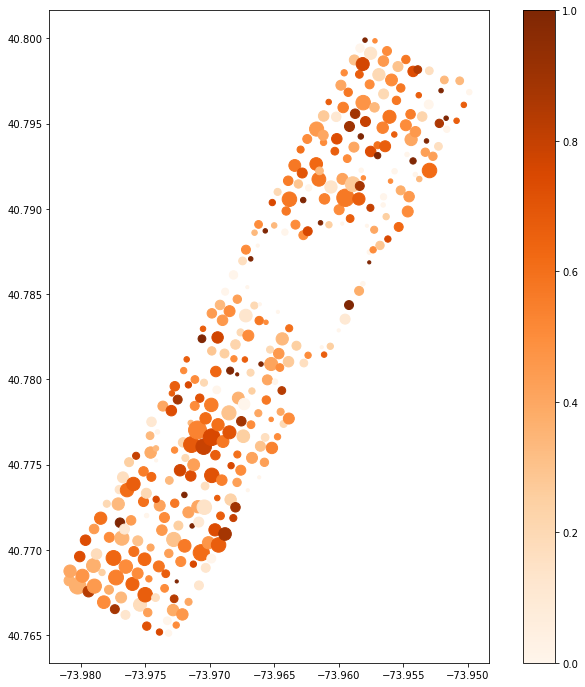

In [70]:
movement_gdf.plot(column = 'foraging',
                  markersize = 'hectare_freq_markersize',
                  cmap = 'Oranges',
                  figsize = (12, 12),
                  legend = True);

In [71]:
communication = ['kuks', 'quaas', 'moans', 'tail_flags', 'tail_twitches']

kuks_int = nyc_gdf2['kuks'].apply(convert_bool_to_int)
quaas_int = nyc_gdf2['quaas'].apply(convert_bool_to_int)
moans_int = nyc_gdf2['moans'].apply(convert_bool_to_int)
tail_flags_int = nyc_gdf2['tail_flags'].apply(convert_bool_to_int)
tail_twitches_int = nyc_gdf2['tail_twitches'].apply(convert_bool_to_int)

nyc_gdf2 = nyc_gdf2.assign(kuks = kuks_int,
                           quaas = quaas_int,
                           moans = moans_int,
                           tail_flags = tail_flags_int,
                           tail_twitches = tail_twitches_int)

nyc_gdf3 = nyc_gdf2.groupby('hectare').mean()

In [72]:
communication_gdf = gpd.GeoDataFrame(nyc_gdf3, geometry = gpd.points_from_xy(nyc_gdf3.long, nyc_gdf3.lat))
communication_gdf = communication_gdf.set_crs('EPSG:4326').assign(hectare_freq = hectare_freq)
communication_gdf['hectare_freq_markersize'] = communication_gdf['hectare_freq'] * 10

### Communication Plot
#### Set column to 'kuks', 'quaas', 'moans', 'tail_flags', or 'tail_twitches'
We see that this information is not very accurate or reliable. 

It is difficult for human observers to keep track of how the squirrels are communicating. 

There is a lot of outside noise and the observer may not be able to hear the sounds of the squirrels. 

Additionally, it is hard to see the tail movements when the squirrel is running fast. 

It is subjective and there may not be a clear distinction between what a tail flag is and what a tail twitch is.

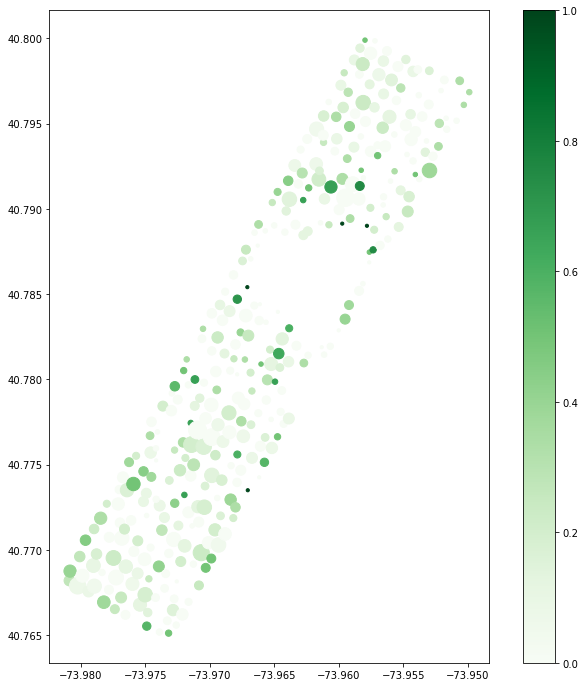

In [73]:
communication_gdf.plot(column = 'tail_twitches',
                      markersize = 'hectare_freq_markersize',
                      cmap = 'Greens',
                      figsize = (12, 12),
                      legend = True);

In [74]:
freq_check_col = ['long', 'lat', 'hectare', 'shift', 'date']
freq_check = nyc_gdf2.get(freq_check_col)
freq_check

long        lat hectare shift      date
0    -73.957044  40.794851     37E    PM  10062018
1    -73.976831  40.766718     02E    AM  10102018
2    -73.975725  40.769703     05D    PM  10182018
3    -73.956570  40.790256     33H    AM  10192018
4    -73.971974  40.769305     06G    PM  10202018
...         ...        ...     ...   ...       ...
2963 -73.963943  40.790868     30B    AM  10072018
2964 -73.970402  40.782560     19A    PM  10132018
2965 -73.966587  40.783678     22D    PM  10122018
2966 -73.963994  40.789915     29B    PM  10102018
2967 -73.975479  40.769640     05E    PM  10122018

[2968 rows x 5 columns]

In [75]:
freq_check_coord = freq_check.groupby(['hectare', 'date', 'shift']).mean()
freq_check_count = freq_check.groupby(['hectare', 'date', 'shift']).count()
freq_check_gdf = gpd.GeoDataFrame(freq_check_coord, 
                                  geometry = gpd.points_from_xy(freq_check_coord.long, freq_check_coord.lat))
freq_check_gdf = freq_check_gdf.set_crs('EPSG:4326')

In [76]:
freq_check_gdf['count'] = freq_check_count['long']
freq_check_gdf['markersize'] = freq_check_gdf['count'] * 10
freq_check_gdf

long        lat                    geometry  \
hectare date     shift                                                     
01A     10072018 AM    -73.980895  40.767989  POINT (-73.98089 40.76799)   
        10142018 PM    -73.980883  40.768317  POINT (-73.98088 40.76832)   
01B     10122018 AM    -73.980221  40.767903  POINT (-73.98022 40.76790)   
        10192018 PM    -73.980274  40.767875  POINT (-73.98027 40.76787)   
01C     10122018 AM    -73.979678  40.767300  POINT (-73.97968 40.76730)   
...                           ...        ...                         ...   
42G     10142018 PM    -73.952014  40.797549  POINT (-73.95201 40.79755)   
        10182018 AM    -73.951657  40.797583  POINT (-73.95166 40.79758)   
42H     10142018 PM    -73.950580  40.797641  POINT (-73.95058 40.79764)   
        10192018 AM    -73.950772  40.797268  POINT (-73.95077 40.79727)   
42I     10142018 PM    -73.949903  40.796850  POINT (-73.94990 40.79685)   

                        count  markersize  
hectare date     shift                     
01A     10072018 AM         4          40  
        10142018 PM         7          70  
01B     10122018 AM        17         170  
        10192018 PM        10         100  
01C     10122018 AM         2          20  
...                       ...         ...  
42G     10142018 PM         3          30  
        10182018 AM         3          30  
42H     10142018 PM         4          40  
        10192018 AM         2          20  
42I     10142018 PM         3          30  

[611 rows x 5 columns]

In [77]:
def hectare_index(row, hectareindex):
    return [index for index in hectareindex if row in index[0]]

hectare_row = '01'

freq_check_noindex = freq_check_gdf.reset_index()
freq_check_barplot = freq_check_noindex[['hectare', 'date', 'shift', 'geometry', 'count', 'markersize']]
freq_check_01 = freq_check_barplot[freq_check_barplot.get('hectare').str.contains(hectare_row)]
freq_check_01

hectare      date shift                    geometry  count  markersize
0      01A  10072018    AM  POINT (-73.98089 40.76799)      4          40
1      01A  10142018    PM  POINT (-73.98088 40.76832)      7          70
2      01B  10122018    AM  POINT (-73.98022 40.76790)     17         170
3      01B  10192018    PM  POINT (-73.98027 40.76787)     10         100
4      01C  10122018    AM  POINT (-73.97968 40.76730)      2          20
5      01C  10132018    PM  POINT (-73.97934 40.76761)     10         100
6      01D  10062018    AM  POINT (-73.97830 40.76694)      9          90
7      01D  10072018    PM  POINT (-73.97811 40.76692)      7          70
8      01E  10062018    AM  POINT (-73.97739 40.76652)      5          50
9      01E  10072018    PM  POINT (-73.97732 40.76653)      3          30
10     01F  10102018    AM  POINT (-73.97659 40.76617)      5          50
11     01F  10192018    PM  POINT (-73.97645 40.76622)      3          30
12     01G  10062018    AM  POINT (-73.97459 40.76551)      4          40
13     01G  10102018    PM  POINT (-73.97528 40.76555)      3          30
14     01H  10122018    AM  POINT (-73.97408 40.76520)      2          20
15     01H  10132018    PM  POINT (-73.97373 40.76516)      2          20
16     01I  10122018    PM  POINT (-73.97320 40.76512)      4          40

In [78]:
freq_check_01_pivot = freq_check_01.pivot(index = 'hectare', columns = 'shift', values = 'count')
freq_check_01_pivot

shift      AM    PM
hectare            
01A       4.0   7.0
01B      17.0  10.0
01C       2.0  10.0
01D       9.0   7.0
01E       5.0   3.0
01F       5.0   3.0
01G       4.0   3.0
01H       2.0   2.0
01I       NaN   4.0

<AxesSubplot:xlabel='hectare'>

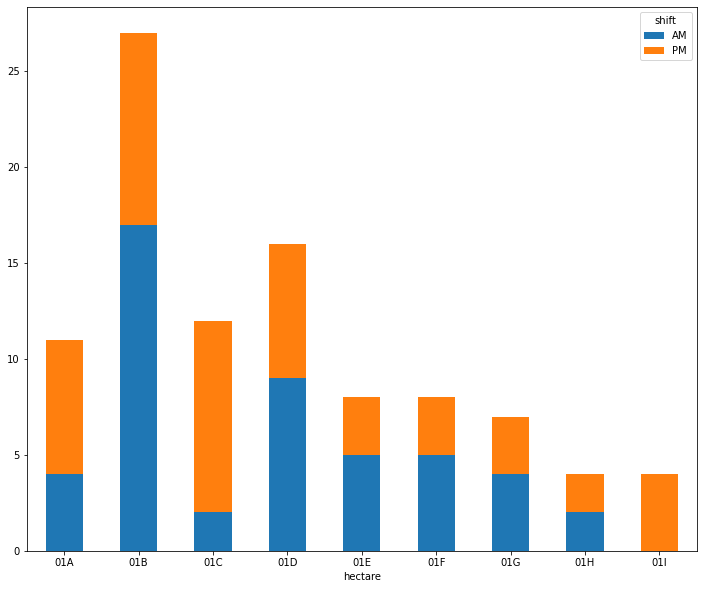

In [79]:
freq_check_01_pivot.plot.bar(stacked = True, 
                             rot = 0,
                             figsize = (12, 10))

In [80]:
nyc_gdf1.get('hectare')

0       37E
1       02E
2       05D
3       33H
4       06G
       ... 
2963    30B
2964    19A
2965    22D
2966    29B
2967    05E
Name: hectare, Length: 2968, dtype: object

<AxesSubplot:>

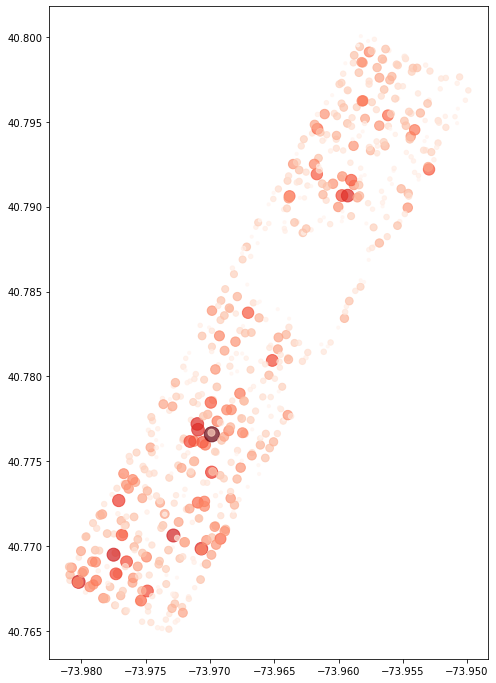

In [81]:
freq_check_gdf.plot(column = 'count', 
                    markersize = 'markersize',
                    cmap = 'Reds',
                    figsize = (12, 12),
                    alpha = 0.7)

## exporting hectare groupby data as csv for ArcGIS

1. reset index
2. groupby
3. add frequency as a column and reset index

In [82]:
nycsquirrels_hectare_groupby = nyc_gdf3.reset_index()
hectare_freq
nyc_hectare_groupby = nycsquirrels_hectare_groupby.set_index('hectare').assign(hectare_freq = hectare_freq).reset_index()
nyc_hectare_groupby

hectare       long        lat   running   chasing  climbing    eating  \
0       01A -73.980887  40.768198  0.090909  0.181818  0.181818  0.090909   
1       01B -73.980241  40.767892  0.185185  0.259259  0.185185  0.444444   
2       01C -73.979395  40.767560  0.083333  0.000000  0.166667  0.083333   
3       01D -73.978215  40.766933  0.250000  0.125000  0.187500  0.125000   
4       01E -73.977362  40.766524  0.000000  0.000000  0.250000  0.000000   
..      ...        ...        ...       ...       ...       ...       ...   
333     42E -73.953892  40.798174  0.500000  0.000000  0.333333  0.166667   
334     42F -73.952999  40.798105  0.666667  0.000000  0.000000  0.166667   
335     42G -73.951835  40.797566  0.500000  0.000000  0.333333  0.166667   
336     42H -73.950644  40.797517  0.500000  0.333333  0.000000  0.166667   
337     42I -73.949903  40.796850  0.333333  0.000000  0.333333  0.333333   

     foraging      kuks  quaas     moans  tail_flags  tail_twitches  \
0    0.363636  0.090909    0.0  0.000000    0.000000       0.272727   
1    0.370370  0.000000    0.0  0.000000    0.037037       0.074074   
2    0.833333  0.000000    0.0  0.000000    0.083333       0.083333   
3    0.500000  0.000000    0.0  0.000000    0.000000       0.375000   
4    0.875000  0.000000    0.0  0.000000    0.000000       0.250000   
..        ...       ...    ...       ...         ...            ...   
333  0.833333  0.166667    0.0  0.000000    0.000000       0.000000   
334  0.166667  0.000000    0.0  0.000000    0.000000       0.166667   
335  0.333333  0.000000    0.0  0.166667    0.000000       0.000000   
336  0.333333  0.000000    0.0  0.000000    0.000000       0.333333   
337  0.000000  0.000000    0.0  0.000000    0.000000       0.333333   

     approaches  indifferent  runs_from                    geometry  \
0      0.000000     0.545455   0.272727  POINT (-73.98089 40.76820)   
1      0.037037     0.851852   0.000000  POINT (-73.98024 40.76789)   
2      0.083333     0.083333   0.166667  POINT (-73.97940 40.76756)   
3      0.000000     0.562500   0.000000  POINT (-73.97821 40.76693)   
4      0.125000     0.500000   0.000000  POINT (-73.97736 40.76652)   
..          ...          ...        ...                         ...   
333    0.000000     0.666667   0.333333  POINT (-73.95389 40.79817)   
334    0.000000     0.833333   0.166667  POINT (-73.95300 40.79810)   
335    0.166667     0.333333   0.666667  POINT (-73.95184 40.79757)   
336    0.000000     0.333333   0.500000  POINT (-73.95064 40.79752)   
337    0.000000     0.666667   0.333333  POINT (-73.94990 40.79685)   

     hectare_freq  
0              11  
1              27  
2              12  
3              16  
4               8  
..            ...  
333             6  
334             6  
335             6  
336             6  
337             3  

[338 rows x 18 columns]

In [83]:
nyc_hectare_groupby.to_csv('nyc_hectare_groupby.csv', index=False, encoding='utf-8')

# machine learning with given dataset


## osm dataframe dictionary
***all geographic data of central park comes from openstreetmaps*** <br>
* `allwaterosm` = water bodies and streams in cp
* `allplaygosm` = playgrounds in cp
* `allpavedosm` = roads and bike paths in cp (paved highways)
* `alltoiletsosm` = toilets in cp
* `allbuildingosm` = buildings in cp (building = yes) and the met
* `allgardenosm` = gardens in cp (leisure = garden)
* `allwoodsosm` = woods in cp (natural = wood)
* `allfieldosm` = open grassy areas in cp (landuse = grass, landuse = recreation_ground)
* `allbarerockosm` = bare rock areas in cp (natural = bare_rock)

In [93]:
# load geojson datasets

centralpark_osm = gpd.read_file('../geojson/centralpark.geojson')
centralpark_water_osm = gpd.read_file('../geojson/water_cp.geojson')
centralpark_stream_osm = gpd.read_file('../geojson/streams_cp.geojson')
centralpark_playg_osm = gpd.read_file('../geojson/playgrounds_cp.geojson')
centralpark_paved_osm = gpd.read_file('../geojson/paved.geojson')
centralpark_toilets_osm = gpd.read_file('geojson/toilets.geojson')
cp_northbd_osm = gpd.read_file('geojson/northbd.geojson')
cp_jorbd_osm = gpd.read_file('geojson/jorbd.geojson')
cp_greatlawnbd_osm = gpd.read_file('geojson/greatlawnbd.geojson')
cp_ramblebd_osm = gpd.read_file('geojson/ramblebd.geojson')
cp_southbd_osm = gpd.read_file('geojson/southbd.geojson')
centralpark_gardens_osm = gpd.read_file('geojson/gardens_cp.geojson')
allwoodsosm = gpd.read_file('geojson/woods_cp.geojson')
cp_baseball_osm = gpd.read_file('geojson/baseballpitch.geojson')
cp_field_osm = gpd.read_file('geojson/field.geojson')
met_osm = gpd.read_file('geojson/met.geojson')
allbarerockosm = gpd.read_file('geojson/bare_rock.geojson')
cp_pedestrian_osm = gpd.read_file('geojson/pedestrian.geojson')
cp_sportscenter_osm = gpd.read_file('geojson/sportscenter.geojson')

DriverError: geojson/water_cp.geojson: No such file or directory

In [ ]:
# allwaterosm

drop_water_osm = ['relation/2389611', 'relation/2389521', 'relation/2389581', 'relation/2389563', 
                  'relation/2212963', 'way/608955193', 
                  'way/375673047', 'way/375673046', 'way/1024586392',
                  'way/727185210', 'way/727185216', 'way/727185221', 'way/727185214', 
                  'way/113690622', 'way/163470962', 'way/260910559', 'way/319615314', 'way/319615316', 
                  'way/394395237', 'way/394395238', 'way/470714268', 'way/988718514', 'way/958630356']

drop_water_index = [centralpark_water_osm[centralpark_water_osm.get('id') == water_id].index[0] for water_id in drop_water_osm]

cp_water_osm = centralpark_water_osm.drop(index=drop_water_index)

allwaterosm = pd.concat([cp_water_osm, centralpark_stream_osm])
allwaterosm = allwaterosm.reset_index().drop(columns = 'index')

# allwaterosm.plot(figsize=(12,12))

In [85]:
# allplaygosm

centralpark_playg_osm.at[23, 'name'] = 'Rudin Family Playground'
centralpark_playg_osm.at[50, 'name'] = 'Safari Playground'
cp_playgrounds_name = ['West 110th Street Playground', 'Tarr Family Playground', 'Rudin Family Playground', 
                       'Robert Bendheim Playground', 'Tarr-Coyne Wild West Playground', '96th Street Playground', 
                       'Abraham and Joseph Spector Playground', 'Arthur Ross Pinetum Playground', 
                       'Diana Ross Playground', 'Ancient Playground', 'Safari Playground',
                       'Ruth and Arthur Smadbeck-Heckscher East Playground', 'Adventure Playground', 
                       'Tarr-Coyne Tots Playground', 'East 72nd Street Playground', 
                       'Billy Johnson Playground', 'Hecksher Playground', 'Mariner\'s Playground']
len(cp_playgrounds_name)

cp_playgrounds_index = []

for name in cp_playgrounds_name:
    cp_playgrounds_index.append(centralpark_playg_osm[centralpark_playg_osm.get('name') == name].index[0])
    
allplaygosm = centralpark_playg_osm.loc[cp_playgrounds_index]
# allplaygosm.plot(figsize=(12,12))

NameError: name 'centralpark_playg_osm' is not defined

In [86]:
# allpavedosm

centralpark_paved_osm[['id','name']]
drop_paved_name = ['Park Avenue', 'Madison Avenue', 'Lexington Avenue', 'York Avenue', 'FDR Drive', 
                   'Riverside Drive', 'West End Avenue', 
                   'Frederick Douglass Boulevard', 'Malcolm X Boulevard',
                   '8th Avenue', '7th Avenue', '6th Avenue', 
                   'East 106th Street', 'East 97th Street', 'East 96th Street', 
                   'East 86th Street', 'East 85th Street', 'East 84th Street', 'East 79th Street',
                   'East 72nd Street', 'East 66th Street', 'East 65th Street',
                   'East 60th Street', 'East 59th Street',
                   'East 73rd Street', 'East 71st Street', 'East 61st Street',
                   'Cathedral Parkway', 'West 110th Street', 'West 106th Street', 'West 96th Street', 
                   'West 95th Street', 'West 86th Street', 'West 81st Street', 'West 79th Street', 
                   'West 75th Street', 'West 72nd Street', 'West 66th Street', 'West 65th Street',
                   'West 62nd Street', 'West 54th Street', 'West 53rd Street']

drop_paved_index = []

for name in drop_paved_name:
    index_list = centralpark_paved_osm[centralpark_paved_osm.get('name') == name].index
    for index in index_list:
        drop_paved_index.append(index)
    
allpavedosm_and5th = centralpark_paved_osm.drop(index = drop_paved_index)

# ways which have the same name as cp bounded ways, use id instead

drop_5th_ends = ['way/988984235', 'way/195743336', 'way/422298615', 'way/962626218', 'way/198924778',
                 'way/840996403', 'way/980855831', 'way/980855832', 'way/980855833', 'way/22898583',
                 'way/46613661', 'way/5670874', 'way/167922075', 
                 'way/584850094', 'way/834058007', 'way/5673363', 'way/584850099']

drop_5th_index = []

for way in drop_5th_ends:
    drop_5th_index.append(allpavedosm_and5th[allpavedosm_and5th.get('id') == way].index[0])

allpavedosm = allpavedosm_and5th.drop(index = drop_5th_index)
# allpavedosm.plot(figsize=(12,12))

NameError: name 'centralpark_paved_osm' is not defined

In [87]:
# alltoiletsosm

drop_toilets = ['node/2329911645', 'node/8539548031', 'node/1310874079', 'node/2339622631', 'way/266919662']

drop_toilets_index = []

for node in drop_toilets:
    drop_toilets_index.append(centralpark_toilets_osm[centralpark_toilets_osm.get('id') == node].index[0])

alltoiletsosm = centralpark_toilets_osm.drop(index = drop_toilets_index)
# alltoiletsosm.plot(figsize=(12,12))

NameError: name 'centralpark_toilets_osm' is not defined

In [88]:
# allbuildingosm

keepbd_columns = ['id', 'alt_name', 'amenity', 'building', 'height', 'name', 'geometry']

# allnorthbdosm

cp_northbd_id = ['way/39243913', 'way/278366155', 'way/278366170', 'way/118729389', 'way/943419152',
                 'way/278366166', 'way/278366163', 'way/278366174']

cp_northbd_index = []

for northbd_id in cp_northbd_id:
    cp_northbd_index.append(cp_northbd_osm[cp_northbd_osm.get('id') == northbd_id].index[0])

allnorthbdosm = cp_northbd_osm.loc[cp_northbd_index].get(keepbd_columns)

# alljorbdosm

cp_jorbd_id = ['way/278363031', 'way/817397167', 'way/278363044']

cp_jorbd_index = []

for jorbd_id in cp_jorbd_id:
    cp_jorbd_index.append(cp_jorbd_osm[cp_jorbd_osm.get('id') == jorbd_id].index[0])
    
alljorbdosm = cp_jorbd_osm.loc[cp_jorbd_index].get(keepbd_columns)

# allgreatlawnbdosm

cp_greatlawnbd_id = ['way/278363039', 'way/278363038', 'way/278363033', 'way/278363041', 'way/278363029',
                     'way/278363036', 'way/278363065', 'way/278363049', 'way/278363046', 'way/278363024', 
                     'way/278363048', 'way/278363035', 'way/278363053']

cp_greatlawnbd_index = []

for greatlawnbd_id in cp_greatlawnbd_id:
    cp_greatlawnbd_index.append(cp_greatlawnbd_osm[cp_greatlawnbd_osm.get('id') == greatlawnbd_id].index[0])
    
allgreatlawnbdosm = cp_greatlawnbd_osm.loc[cp_greatlawnbd_index].get(keepbd_columns)

# allramblebdosm

cp_ramblebd_id = ['way/278361406', 'way/278361407', 'way/775820359', 'relation/3698871', 
                  'way/354587581', 'way/354587583', 'way/265347581', 'way/265347585', 
                  'way/362647331', 'way/265347579', 'way/265347587']

cp_ramblebd_index = []

for ramblebd_id in cp_ramblebd_id:
    cp_ramblebd_index.append(cp_ramblebd_osm[cp_ramblebd_osm.get('id') == ramblebd_id].index[0])
    
allramblebdosm = cp_ramblebd_osm.loc[cp_ramblebd_index].get(keepbd_columns)

# allsouthbdosm

cp_southbd_id = ['way/265347589', 'way/585788256', 'way/265347597', 'way/265347588', 'way/265347593',
                 'way/321166650', 'way/321166649', 'way/265347596', 'way/265347590', 'way/265347591',
                 'way/385442739', 'way/265347586', 'way/265347592']

cp_southbd_index = []

for southbd_id in cp_southbd_id:
    cp_southbd_index.append(cp_southbd_osm[cp_southbd_osm.get('id') == southbd_id].index[0])
    
allsouthbdosm = cp_southbd_osm.loc[cp_southbd_index].get(keepbd_columns)

# metosm

allmetosm = met_osm[met_osm.get('name') == 'The Metropolitan Museum of Art']

# concatenate all df

allbuildingosm = pd.concat([allnorthbdosm, alljorbdosm, allgreatlawnbdosm, allramblebdosm, allsouthbdosm, allmetosm])

# allbuildingosm.plot(figsize = (12,12))

NameError: name 'cp_northbd_osm' is not defined

In [89]:
# allgardenosm

drop_garden = ['way/362826846', 'way/169915675', 'way/330448922', 'way/313994014', 'way/202503285',
               'way/225189389', 'way/796333282', 'way/225188744']

drop_garden_index = [centralpark_gardens_osm[centralpark_gardens_osm.get('id') == way].index[0] for way in drop_garden]
    
allgardenosm = centralpark_gardens_osm.drop(index = drop_garden_index)

# allgardenosm.plot(figsize = (12,12))

NameError: name 'centralpark_gardens_osm' is not defined

In [90]:
# allbaseballosm

drop_baseball = ['way/667343443', 'way/920569850', 'way/920569847', 'way/319797239']

drop_baseball_index = [cp_baseball_osm[cp_baseball_osm.get('id') == way].index[0] for way in drop_baseball]

allbaseballosm = cp_baseball_osm.drop(index = drop_baseball_index)
# allbaseballosm.plot(figsize = (12, 12))

NameError: name 'cp_baseball_osm' is not defined

In [91]:
# allfieldosm

drop_field = ['way/188692199', 'way/951525207', 'way/951525216', 'way/951525219', 
              'way/951539223', 'way/951539207', 'way/951539204', 'way/951539221', 'way/951539203', 'way/951539215',
              'way/951539218', 'way/951525211', 'way/951539232', 'way/951525215', 'way/951525217',
              'way/951539196', 'way/951525222', 'way/951525209', 'way/972597724',
              'way/949457222', 'way/949457226', 'way/953189819', 'way/849307005', 'way/849307011', 'way/849307012',
              'way/849307006', 'way/952333244', 'way/849307009', 'way/953189823', 'way/952333240', 'way/949532332',
              'way/949848463', 'way/949851336', 'way/667981482', 'way/949848467', 'way/949848466',
              'way/833371440', 'way/949848471', 'way/949848459', 'way/949848457',
              'way/849046450', 'way/849046418', 'way/849046432', 'way/849046434', 'way/849046451',
              'way/849046431', 'way/849046424', 'way/849046433', 'way/849046423', 'way/667981479', 'way/667981483',
              'way/667981480', 'way/849046437', 'way/849046453', 'way/849046448', 'way/849046420',
              'way/849046440', 'way/849046435', 'way/849046417', 'way/849299252', 'way/849299251', 'way/949848465',
              'way/849046452', 'way/849046454', 'way/849046415', 'way/667981478', 'way/849046438', 'way/849046427',
              'way/849046421', 'way/849046429', 'way/849046457', 'way/849046428',
              'way/849046444', 'way/849046441', 'way/849046426', 'way/849046414', 'way/949848462']

drop_field_index = [cp_field_osm[cp_field_osm.get('id') == way].index[0] for way in drop_field]

allfieldosm = cp_field_osm.drop(index = drop_field_index)

# allfieldosm.plot(figsize = (12, 12))

NameError: name 'cp_field_osm' is not defined

In [92]:
# allpedestrianosm

drop_ped = ['relation/4623434', 'relation/4623433', 'relation/4623431', 'way/1031859264', 'way/321166645',
            'relation/2280942', 'way/329988122', 'way/329988123', 'way/458452177', 'way/710571385', 
            'way/375314249', 'way/338043682', 'way/46340036', 'way/710571377', 'way/5671777']

drop_ped_index = [cp_pedestrian_osm[cp_pedestrian_osm.get('id') == ped].index[0] for ped in drop_ped]

allpedestrianosm = cp_pedestrian_osm.drop(index=drop_ped_index)

# allpedestrianosm.plot(figsize=(12,12))

NameError: name 'cp_pedestrian_osm' is not defined

In [31]:
# allspcenterosm

drop_spcenter = ['node/368062558', 'node/2724236668', 'node/5607297102']

drop_spcenter_index = [cp_sportscenter_osm[cp_sportscenter_osm.get('id') == spcenter].index[0] for spcenter in drop_spcenter]

allspcenterosm = cp_sportscenter_osm.drop(index=drop_spcenter_index)


NameError: name 'cp_sportscenter_osm' is not defined

In [32]:
transparency = 0.5

base = allwaterosm.plot(color = '#1795e8', alpha = transparency,
                        figsize = (12, 12))

allplaygosm.plot(color = '#d96866', alpha = transparency,
                 ax = base)

allpavedosm.plot(color = 'Black', alpha = transparency,
                 ax = base)

alltoiletsosm.plot(color = '#737373', alpha = transparency,
                   ax = base)

allbuildingosm.plot(color = '#ad6f03', alpha = transparency,
                   ax = base)

allgardenosm.plot(color = '#ff8cec', alpha = transparency,
                  ax = base)

allwoodsosm.plot(color = '#098f57', alpha = transparency,
                 ax = base)

allfieldosm.plot(color = '#86b35d', alpha = transparency,
                 ax = base)

allbarerockosm.plot(color = '#6b6865', alpha = transparency,
                  ax = base)

allpedestrianosm.plot(color = 'Black', alpha = transparency,
                     ax = base)

allbaseballosm.plot(color = '#c4a782', alpha = transparency,
                  ax = base)

allspcenterosm.plot(color = '#960906', alpha = transparency,
                 ax = base)

# human_int_gdf.plot(column = 'runs_from', 
                   #markersize = 'hectare_freq_markersize', 
                   #cmap = 'plasma_r',
                   #figsize = (12, 12), 
                   #legend = True,
                   #ax = base)

nyc_gdf2.plot(column = 'runs_from',
              legend = True,
              markersize = 7,
              ax = base)

# nyc_gdf2.plot(ax = base, color = 'black', markersize = 7)

# nyc_gdf2.plot(color = 'Gray', legend = True, ax = base)

NameError: name 'allwaterosm' is not defined

In [33]:
allwaternatural = allwaterosm.get('natural')
allwaterwaterway = allwaterosm.get('waterway')


allwaterosm_keep = ['id', 'geometry', 'name', 'natural', 'waterway']
centralparkwater = allwaterosm[allwaterosm_keep]
feature_type = centralparkwater['natural'].fillna(centralparkwater['waterway'])
centralparkwater = centralparkwater.assign(feature_type = feature_type).drop(columns = ['natural', 'waterway'])

allpavedosm_keep = ['id', 'geometry', 'name', 'highway', 'route']
centralparkpaved = allpavedosm[allpavedosm_keep].reset_index().drop(columns='index')
centralparkpaved = centralparkpaved.assign(feature_type = 'paved').drop(columns = ['highway', 'route'])

allgardenosm_keep = ['id', 'geometry', 'name', 'leisure']
centralparkgarden = allgardenosm[allgardenosm_keep]
centralparkgarden = centralparkgarden.assign(feature_type = centralparkgarden.get('leisure')).drop(columns = 'leisure')

allbaseball_keep = ['id', 'geometry', 'name', 'leisure', 'sport']
centralparkbaseball = allbaseballosm[allbaseball_keep]
centralparkbaseball = centralparkbaseball.assign(feature_type = 'pitch: baseball').drop(columns = ['leisure', 'sport'])

allwoods_keep = ['id', 'geometry', 'name', 'natural']
centralparkwoods = allwoodsosm[allwoods_keep]
centralparkwoods = centralparkwoods.assign(feature_type = centralparkwoods.get('natural')).drop(columns = 'natural')

allfields_keep = ['id', 'geometry', 'name', 'landuse']
centralparkfields = allfieldosm[allfields_keep]
centralparkfields = centralparkfields.assign(feature_type = 'grass').drop(columns = 'landuse')

allplayg_keep = ['id', 'geometry', 'name', 'leisure']
centralparkplayg = allplaygosm[allplayg_keep]
centralparkplayg = centralparkplayg.assign(feature_type = 'playground').drop(columns = 'leisure')

allbuild_keep = ['id', 'geometry', 'name', 'building']
centralparkbuilding = allbuildingosm[allbuild_keep]
centralparkbuilding = centralparkbuilding.assign(feature_type = 'building').drop(columns = 'building')

allspcenter_keep = ['id', 'geometry', 'name', 'leisure']
centralparkspcenter = allspcenterosm[allspcenter_keep]
centralparkspcenter = centralparkspcenter.assign(feature_type = 'sports center').drop(columns = 'leisure')

allped_keep = ['id', 'geometry', 'name', 'highway']
centralparkpedestrian = allpedestrianosm[allped_keep]
centralparkpedestrian = centralparkpedestrian.assign(feature_type = 'pedestrian').drop(columns = 'highway')

allrock_keep = ['id', 'geometry', 'name', 'natural']
centralparkrock = allbarerockosm[allrock_keep]
centralparkrock = centralparkrock.assign(feature_type = 'bare_rock').drop(columns = 'natural')

alltoilet_keep = ['id', 'geometry', 'name', 'amenity']
centralparktoilet = alltoiletsosm[alltoilet_keep]
centralparktoilet = centralparktoilet.assign(feature_type = 'toilet').drop(columns = 'amenity')

centralparkfeatures = pd.concat([centralparkgarden, centralparkwater, centralparkfields, 
                                 centralparkwoods,
                                 centralparkbuilding,
                                 centralparkpedestrian])

centralparkfeaturescmap = ['#ad6f03', '#ff8cec', '#86b35d', '#000000',
                           '#1795e8', '#1795e8', '#098f57']

centralparkfeaturesmap = centralparkfeatures.explore(column='feature_type',
                                                     tooltip=['feature_type', 'name'],
                                                     popup=True,
                                                     tiles="cartodbpositron",
                                                     cmap = centralparkfeaturescmap,
                                                     max_zoom = 10)

centralparkfeaturesmap


NameError: name 'allwaterosm' is not defined

In [34]:
nyc_gdf2_keep = ['hectare', 'shift', 'date', 'primary_fur_color', 'geometry']

nyc_gdf2[nyc_gdf2_keep].explore(m = centralparkfeaturesmap)

NameError: name 'nyc_gdf2' is not defined

In [35]:
centralparkfeaturesmap.save('centralparkfeaturesandsquirrelsmap.html')

NameError: name 'centralparkfeaturesmap' is not defined

In [36]:
centralparkfeaturesmap.save('centralparkfeaturesmap.html')

NameError: name 'centralparkfeaturesmap' is not defined

In [37]:
osmcp = folium.Map(location=[40.783121, -73.965750], zoom_start=14, max_zoom=15)

In [38]:
epsg2263_nyc_gdf2 = nyc_gdf2.to_crs('epsg:2263')


epsg2263_allwaterosm = allwaterosm.to_crs('epsg:2263')
allwaterosm_buffer = epsg2263_allwaterosm.geometry.buffer(100)
folium.GeoJson(allwaterosm_buffer).add_to(osmcp)

waterbufferunion = allwaterosm_buffer.geometry.unary_union
sqrinwater = epsg2263_nyc_gdf2.within(waterbufferunion)

# folium.GeoJson(epsg2263_nyc_gdf2.loc[sqrinwater])

#base_water = allwaterosm.plot(figsize=(24,24))

#nyc_gdf2.plot(ax = base, color = 'gray')

nyc_gdf2.loc[sqrinwater].plot(ax = base, color = 'red')

NameError: name 'nyc_gdf2' is not defined

In [39]:
# Turn group of polygons into single multipolygon
my_union = onehundredftbuffer.geometry.unary_union
#print('Type:', type(my_union))

# Show the MultiPolygon object
onehundredftbuffergdf = gpd.GeoDataFrame(onehundredftbuffer).assign(geometry = onehundredftbuffer).get(['geometry'])
squirrelinwater = distance_nyc_gdf2.within(my_union)

base_1 = allwaterosm.to_crs('epsg:2263').explore()

folium.GeoJson(distance_nyc_gdf2).add_to(base_1)

folium.GeoJson(distance_nyc_gdf2.loc[squirrelinwater]).add_to(base_1)

# distance_nyc_gdf2.plot(ax = base_1, color='gray')

# distance_nyc_gdf2.loc[squirrelinwater].plot(ax = base_1, color='red')

print(len(distance_nyc_gdf2.loc[squirrelinwater]) / len(distance_nyc_gdf2))


NameError: name 'onehundredftbuffer' is not defined

In [40]:
bufferconv_nyc_gdf2 = nyc_gdf2.to_crs('epsg: 2263')

# areas where squirrels may be found

bufferconv_cprock = centralparkrock.to_crs('epsg: 2263')
geom_cprock = bufferconv_cprock.geometry
geom_cprock_union = geom_cprock.geometry.unary_union
squirrelinrock = bufferconv_nyc_gdf2.within(geom_cprock_union)

bufferconv_cpfields = centralparkfields.to_crs('epsg: 2263')
geom_cpfields = bufferconv_cpfields.geometry
geom_cpfields_union = geom_cpfields.geometry.unary_union
squirrelinfields = bufferconv_nyc_gdf2.within(geom_cpfields_union)

bufferconv_cpwoods = centralparkwoods.to_crs('epsg: 2263')
geom_cpwoods = bufferconv_cpwoods.geometry
geom_cpwoods_union = geom_cpwoods.geometry.unary_union
squirrelinwoods = bufferconv_nyc_gdf2.within(geom_cpwoods_union)

bufferconv_cpgarden = centralparkgarden.to_crs('epsg: 2263')
geom_cpgarden = bufferconv_cpgarden.geometry
geom_cpgarden_union = geom_cpgarden.geometry.unary_union
squirrelingarden = bufferconv_nyc_gdf2.within(geom_cpgarden_union)

bufferconv_cppg = centralparkplayg.to_crs('epsg: 2263')
geom_cppg = bufferconv_cppg.geometry
geom_cppg_union = geom_cppg.geometry.unary_union
squirrelinpg = bufferconv_nyc_gdf2.within(geom_cppg_union)

bufferconv_cppede = centralparkpedestrian.to_crs('epsg: 2263')
geom_cppede = bufferconv_cppede.geometry
geom_cppede_union = geom_cppede.geometry.unary_union
squirrelinpedestrian = bufferconv_nyc_gdf2.within(geom_cppede_union)

bufferconv_cpbaseball = centralparkbaseball.to_crs('epsg: 2263')
geom_cpbaseball = bufferconv_cpbaseball.geometry
geom_cpbaseball_union = geom_cpbaseball.geometry.unary_union
squirrelinbaseball = bufferconv_nyc_gdf2.within(geom_cpbaseball_union)

bufferconv_cpsp = centralparkspcenter.to_crs('epsg: 2263')
geom_cpsp = bufferconv_cpsp.geometry
geom_cpsp_union = geom_cpsp.geometry.unary_union
squirrelinspcenter = bufferconv_nyc_gdf2.within(geom_cpsp_union)

bufferconv_cptoilet = centralparktoilet.to_crs('epsg: 2263')
geom_cptoilet = bufferconv_cptoilet.geometry
geom_cptoilet_union = geom_cptoilet.geometry.unary_union
squirrelintoilet = bufferconv_nyc_gdf2.within(geom_cptoilet_union)

# areas where squirrels shouldn't be in 

bufferconv_cpbuild = centralparkbuilding.to_crs('epsg: 2263')
geom_cpbuild = bufferconv_cpbuild.geometry
geom_cpbuild_union = geom_cpbuild.geometry.unary_union
squirrelinbuilding = bufferconv_nyc_gdf2.within(geom_cpbuild_union)

bufferconv_cpwater = centralparkwater.to_crs('epsg: 2263')
geom_cpwater = bufferconv_cpwater.geometry
geom_cpwater_union = geom_cpwater.geometry.unary_union
squirrelinwater = bufferconv_nyc_gdf2.within(geom_cpwater_union)

NameError: name 'nyc_gdf2' is not defined

In [41]:
rock_area = sum(bufferconv_cprock['geometry'].area)
sum(squirrelinrock) / rock_area

NameError: name 'bufferconv_cprock' is not defined

In [42]:
fields_area = sum(bufferconv_cpfields['geometry'].area)
sum(squirrelinfields) / fields_area

NameError: name 'bufferconv_cpfields' is not defined

In [43]:
woods_area = sum(bufferconv_cpwoods['geometry'].area)
sum(squirrelinwoods) / woods_area

NameError: name 'bufferconv_cpwoods' is not defined

In [44]:
garden_area = sum(bufferconv_cpgarden['geometry'].area)
sum(squirrelingarden) / garden_area

NameError: name 'bufferconv_cpgarden' is not defined

In [ ]:
pg_area = sum(bufferconv_cppg['geometry'].area)
sum(squirrelinpg) / pg_area

In [45]:
build_area = sum(bufferconv_cpbuild['geometry'].area)
sum(squirrelinbuilding) / build_area

NameError: name 'bufferconv_cpbuild' is not defined

In [46]:
water_area = sum(bufferconv_cpwater['geometry'].area)
sum(squirrelinwater) / water_area

NameError: name 'bufferconv_cpwater' is not defined

In [47]:
sum(squirrelinrock), sum(squirrelinfields), sum(squirrelinwoods), sum(squirrelingarden), sum(squirrelinpg), \
sum(squirrelinbuilding), sum(squirrelinwater), sum(squirrelinpedestrian), sum(squirrelinbaseball), \
                            sum(squirrelinspcenter), sum(squirrelintoilet)

NameError: name 'squirrelinrock' is not defined

In [48]:
bufferconv_cp = centralpark_osm.take([1]).to_crs('epsg: 2263')
cp_area = sum(bufferconv_cp['geometry'].area)

NameError: name 'centralpark_osm' is not defined

In [49]:
('bare_rock', rock_area/cp_area), ('fields and grass', fields_area/cp_area), \
('woods', woods_area/cp_area), ('garden', garden_area/cp_area), \
('playground', pg_area/cp_area), ('building', build_area/cp_area), ('water', water_area/cp_area)

NameError: name 'rock_area' is not defined

In [50]:
water_gdf = bufferconv_nyc_gdf2.assign(inwater = squirrelinwater)
water_gdf[water_gdf.get('inwater') == True].explore()

NameError: name 'bufferconv_nyc_gdf2' is not defined

In [51]:
building_gdf = bufferconv_nyc_gdf2.assign(inbuilding = squirrelinbuilding)
building_gdf[building_gdf.get('inbuilding') == True].explore()

NameError: name 'bufferconv_nyc_gdf2' is not defined

In [52]:
centralpark_osm

NameError: name 'centralpark_osm' is not defined

In [53]:
centralparkperimeter = centralpark_osm[centralpark_osm.get('id') == 'way/427818536']

bufferconv_cpperi = centralparkperimeter.to_crs('epsg: 2263')
geom_cpperi = bufferconv_cpperi.geometry
geom_cpperi_union = geom_cpperi.geometry.unary_union
squirrelinside = bufferconv_nyc_gdf2.within(geom_cpperi_union)

NameError: name 'centralpark_osm' is not defined

In [54]:
outside = bufferconv_nyc_gdf2.assign(inside = squirrelinside)
outside[outside.get('inside') == False].explore()

NameError: name 'bufferconv_nyc_gdf2' is not defined

In [55]:
centralparkpaved = centralparkpaved.to_crs('epsg: 2263')

centralpark_perimeter = centralparkpaved[(centralparkpaved.get('name') == '5th Avenue') |
                                         (centralparkpaved.get('name') == 'Central Park North') |
                                         (centralparkpaved.get('name') == 'Central Park West') |
                                         (centralparkpaved.get('name') == 'Central Park South') |
                                         (centralparkpaved.get('name') == 'Grand Army Plaza') |
                                         (centralparkpaved.get('name') == 'Doris C. Freedman Place') |
                                         (centralparkpaved.get('name') == 'Duke Ellington Circle')]

NameError: name 'centralparkpaved' is not defined

In [56]:
centralparkperi = centralpark_perimeter.unary_union.convex_hull
squirrelinside = bufferconv_nyc_gdf2.within(centralparkperi)

NameError: name 'centralpark_perimeter' is not defined

In [57]:
inside_gdf = bufferconv_nyc_gdf2.assign(inside = squirrelinside)
inside_gdf[inside_gdf.get('inside') == False].explore()

NameError: name 'bufferconv_nyc_gdf2' is not defined

In [58]:
rock_gdf = bufferconv_nyc_gdf2.assign(rock = squirrelinrock)
rock_gdf[rock_gdf.get('rock') == True]

NameError: name 'bufferconv_nyc_gdf2' is not defined